In [1]:
import subprocess
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

def run_experiment(model_param_file, train_adj_feature_file, fractionlabelsattack):
    print(f"Running experiment")

    command = [
        "python", "main.py",
        '--model_param_file', model_param_file,
        '--train_adj_feature_file', train_adj_feature_file,
        '--nlabel' , str(fractionlabelsattack)
    ]

    result = subprocess.run(command, capture_output=True, text=True, encoding='utf-8')

    output = result.stdout
    match = re.search(r"AUC:\s*([\d.]+).*AP:\s*([\d.]+)", output, re.DOTALL)
    if match:
        auc = float(match.group(1))
        ap = float(match.group(2))
    else:
        auc, ap = None, None

    return auc, ap


In [2]:
params = ['model_cora_ml_nosampling.npz', 'model_cora_ml_sampling50pct.npz', 'model_cora_ml_sampling9pct.npz']
results = []
for i in params:
    auc, ap = run_experiment(i, 'matricx.npz', 1)
    results.append([i, auc, ap])


Running experiment
Running experiment
Running experiment


In [3]:
print(results)

[['model_cora_ml_nosampling.npz', 0.723008, 0.761437], ['model_cora_ml_sampling50pct.npz', 0.673514, 0.633049], ['model_cora_ml_sampling9pct.npz', 0.679632, 0.64809]]


Comparing the attack AUC and AP for Cora_ML dataset for different DPAR Training settings i.e DPAR trained with different sampling rates of the training graph

Text(0.5, 1.0, 'Effect of sampling in DPAR training on the Attack Performance')

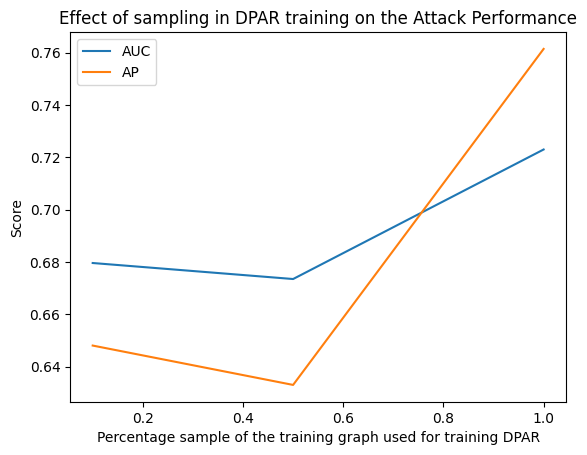

In [4]:
plt.plot([1, 0.5, 0.1], [r[1] for r in results], label='AUC')
plt.plot([1, 0.5, 0.1], [r[2] for r in results], label='AP')
plt.legend()
plt.xlabel('Percentage sample of the training graph used for training DPAR')
plt.ylabel('Score')
plt.title('Effect of sampling in DPAR training on the Attack Performance')

Comparing the attack performance based on the number of training labels known to the adversary

In [4]:
results1=  []

for i in range(1,10):
    auc, ap = run_experiment('model_cora_ml_nosampling.npz', 'matricx.npz', i/10)
    results1.append([i/10, auc, ap])

Running experiment
Running experiment
Running experiment
Running experiment
Running experiment
Running experiment
Running experiment
Running experiment
Running experiment


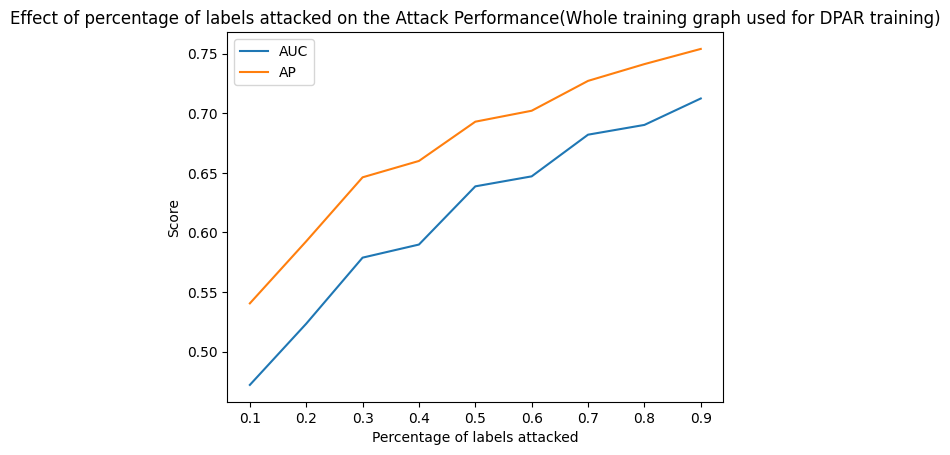

In [5]:
plt.plot([r[0] for r in results1], [r[1] for r in results1], label='AUC')
plt.plot([r[0] for r in results1], [r[2] for r in results1], label='AP')
plt.legend()
plt.xlabel('Percentage of labels attacked')
plt.ylabel('Score')
plt.title('Effect of percentage of labels attacked on the Attack Performance(Whole training graph used for DPAR training)')
plt.show()

In [6]:
results2=  []

for i in range(1,10):
    auc, ap = run_experiment('model_cora_ml_sampling50pct.npz', 'matricx.npz', i/10)
    results2.append([i/10, auc, ap])

Running experiment
Running experiment
Running experiment
Running experiment
Running experiment
Running experiment
Running experiment
Running experiment
Running experiment


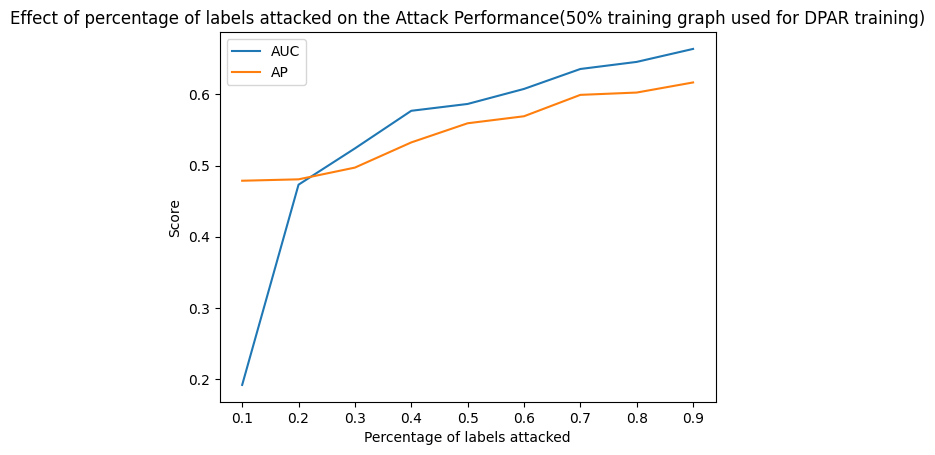

In [7]:
plt.plot([r[0] for r in results2], [r[1] for r in results2], label='AUC')
plt.plot([r[0] for r in results2], [r[2] for r in results2], label='AP')
plt.legend()
plt.xlabel('Percentage of labels attacked')
plt.ylabel('Score')
plt.title('Effect of percentage of labels attacked on the Attack Performance(50% training graph used for DPAR training)')
plt.show()